# Photogrammetric Optode Coregistration

In [ ]:
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import logging
logging.basicConfig()
logging.getLogger("cedalion").setLevel(logging.DEBUG)
logging.getLogger('trame_client').setLevel(logging.WARNING)
logging.getLogger('trame_server').setLevel(logging.WARNING)

import cedalion
import cedalion.io
import cedalion.datasets
import cedalion.plots
from cedalion.geometry.photogrammetry.processors import ColoredStickerProcessor, geo3d_from_scan
import xarray as xr
import pyvista as pv
import numpy as np
import cedalion.geometry.registration
import cedalion.dataclasses as cdc
from cedalion.plots import OptodeSelector


from cedalion.geometry.landmarks import order_ref_points_6
from cedalion.geometry.registration import icp_with_full_transform, find_spread_points

xr.set_options(display_expand_data=False);


## Choose between interactive and static 3D plots
Note that for optode and landmark picking you need interactive plots. Static plots are mainly useful for rendering this example notebook. 

In [6]:
pv.set_jupyter_backend("client")  # uncomment for static rendering (used for documentation page)
#pv.set_jupyter_backend("server")  # uncomment for interactive rendering

Use `cedalion.io.read_einstar_obj` to read the textured triangle mesh produced by the Einstar scanner. Here, we use our example dataset.

In [7]:
""" 
# insert here your own file if you do not want to use the example file
fname_scan = "" # path to .obj scan file
"""
fname_scan, fname_snirf,fname_montage = cedalion.datasets.get_photogrammetry_example_scan()
s = cedalion.io.read_einstar_obj(fname_scan)

Processors are meant to analyze the textured mesh and extract positions. The ColoredStickerProcessor searches for colored circular areas. The colors must be specified by their ranges in hue and value. These can for example be found by usig a color pipette tool on the texture file.

In the following to classes of stickers are searched: "O(ptodes)" in blue and "L(andmarks" in yellow.

In [ ]:
processor = ColoredStickerProcessor(
    colors={
        "O" : ((0.11, 0.21, 0.7, 1)), # (hue_min, hue_max, value_min, value_max)
        #"L" : ((0.25, 0.37, 0.35, 0.6))
    }
)

sticker_centers, normals, details = processor.process(s, details=True)
display(sticker_centers)

Visualize the surface and extraced results.

In [ ]:
pvplt = pv.Plotter()
cedalion.plots.plot_surface(pvplt, s, opacity=1.0)
cedalion.plots.plot_labeled_points(pvplt, sticker_centers, color="r")
cedalion.plots.plot_vector_field(pvplt, sticker_centers, normals)
pvplt.show()

The details object is meant as a container for debuging information. It also provides plotting functionality.The following scatter plot shows the vertex colors in the hue-value plane in which the vertex classification operates.

In [ ]:
details.plot_vertex_colors()

The following plots show for each cluster (tentative group of sticker vertices) The vertex positions perpendicular to the sticker normal as well as the minimum enclosing circle which is used to find the sticker's center.

In [ ]:
details.plot_cluster_circles()

### If not all optodes were found automatically, there's way to remove or add them manually

In [ ]:
visualizer = OptodeSelector(s, sticker_centers, normals)
visualizer.plot()
visualizer.enable_picking()
cedalion.plots.plot_surface(visualizer.plotter, s, opacity=1.0)
visualizer.plotter.show()

After selecting all optodes, update sticker_centers and normals:

In [36]:
sticker_centers = visualizer.points
normals = visualizer.normals if visualizer.normals is not None else normals

Finally, to get from the sticker centers to the scalp coordinates we have to subtract the lenght of the optodes in the direction of the normals:

In [ ]:
optode_length = 22.6 * cedalion.units.mm

scalp_coords = sticker_centers.copy()
mask_optodes = sticker_centers.group == 'O'
scalp_coords[mask_optodes] = sticker_centers[mask_optodes] - optode_length*normals[mask_optodes]
# we make a copy of this raw set of scalp coordinates to use later in the 2nd case of the coregistration example 
# that showcases an alternative route if landmark-based coregistration fails
scalp_coords_altcase = scalp_coords.copy()

display(scalp_coords)

In [ ]:
pvplt = pv.Plotter()
cedalion.plots.plot_surface(pvplt, s, opacity=0.3)
cedalion.plots.plot_labeled_points(pvplt, sticker_centers, color="r")
cedalion.plots.plot_labeled_points(pvplt, scalp_coords, color="g")
cedalion.plots.plot_vector_field(pvplt, sticker_centers, normals)
pvplt.show()

### Select landmarks on a head surface
* pick_landmarks parameter is set to *True*

In [ ]:
pvplt = pv.Plotter()
get_landmarks = cedalion.plots.plot_surface(pvplt, s, opacity=1.0, pick_landmarks = True)
pvplt.show(interactive = True)

### Get landmarks from the plot
Call *get_landmarks* from the previous cell. 
* 1st value - coordinates of picked landmarks
* 2nd - labels of corresponding landmarks

In [ ]:
# for documentation purposes and to enable automatically rendered example notebooks we provide the hand-picked coordinates here too.
landmark_labels = ['Nz', 'Iz', 'Cz', 'Lpa', 'Rpa']
landmark_coordinates = [np.array([14.00420712, -7.84856869, 449.77840004]), 
                                  np.array([99.09920059, 29.72154755, 620.73876117]),
                                  np.array([161.63815139, -48.49738938, 494.91210993]),
                                  np.array([82.8771277, 79.79500128, 498.3338802]),
                                  np.array([15.17214095, -60.56186128, 563.29621021])]

# uncomment if you want to use your manually picked landmarks
# landmark_coordinates, landmark_labels = get_landmarks()
landmark_labels

### Write landmarks to xarray.DataArray structure

* insert *landmark_coordinates* and *landmark_labels*

In [ ]:
coordinates = landmark_coordinates
labels = landmark_labels

types = [cdc.PointType.LANDMARK]*5
groups = ["L"]*5

landmarks = xr.DataArray(
    np.vstack(coordinates),
    dims=["label", "digitized"],
    coords={
        "label": ("label", labels),
        "type": ("label", types),
        "group": ("label", groups),
    },
).pint.quantify("mm")

display(landmarks)

### Load the montage information from .snirf file


In [ ]:
""" 
# insert here your own file if you do not want to use the example file
fname_snirf = "" # path to .snirf file 
"""
# read the example snirf file
recording = cedalion.io.read_snirf(fname_snirf)
rec = recording[0]

# read 3D coordinates of the optodes
montage_elements = rec.geo3d
montage_elements = montage_elements.rename({"pos" : "aligned"})
montage_elements

### Find a transformation to align selected landmarks to montage coordinates

Visualization of initial alignment of optode positions from .snirf file

* Blue for detectors
* Red for sources


In [ ]:
trafo = cedalion.geometry.registration.register_trans_rot(landmarks, montage_elements)


filtered_montage_elements = montage_elements.where((montage_elements.type == cdc.PointType.SOURCE) | (montage_elements.type == cdc.PointType.DETECTOR), drop=True)
filtered_montage_elements_t = filtered_montage_elements.points.apply_transform(trafo)
pvplt = pv.Plotter()
cedalion.plots.plot3d(None, s.mesh, filtered_montage_elements_t, None, plotter = pvplt) 
pvplt.show()


### Iterative closest point algorithm to find labels for detectes optode centers

Visualization of labels assignment

* Green points represent optode centers
* Next to them there shall be labels assumed by ICP algorithm (*show_labels = True*)

In [ ]:
# iterative closest point registration
idx = cedalion.geometry.registration.icp_with_full_transform(scalp_coords, 
                                                                            filtered_montage_elements_t, max_iterations = 100) 
# extract labels for detected optodes
label_dict = {}
for i, label in enumerate(filtered_montage_elements.coords['label'].values):
    label_dict[i] = label
labels = [label_dict[index] for index in idx]

# write labels to scalp_coords
scalp_coords = scalp_coords.assign_coords(label=labels)


## visualize results
# Green points represent optode centers
# Next to them there shall be labels assumed by ICP algorithm (*show_labels = True*)
pvplt = pv.Plotter()
cedalion.plots.plot3d(None, s.mesh, filtered_montage_elements_t, None, plotter = pvplt) 
cedalion.plots.plot_labeled_points(pvplt, scalp_coords, color="green", show_labels = True)
pvplt.show(interactive = True)

Extract labels for detected optodes

### Combine all coregistered points into a new geo3d for further use 
e.g. (to save or update an existing geo3D field in a recording  container)

In [45]:
geo3Dscan = geo3d_from_scan(scalp_coords, landmarks)

Visualization of successfull assignment *(show_labels = True)*

In [ ]:
pvplt = pv.Plotter()
cedalion.plots.plot3d(None, s.mesh, None, None, plotter = pvplt) 
cedalion.plots.plot_labeled_points(pvplt, geo3Dscan, show_labels = True)
pvplt.show()

## If labels are wrong (e.g. landmarks are faulty)

It is possible to find a new transformation by manually labeling 3 optodes by selecting them in a given order. For that you need the montage of your experiment.

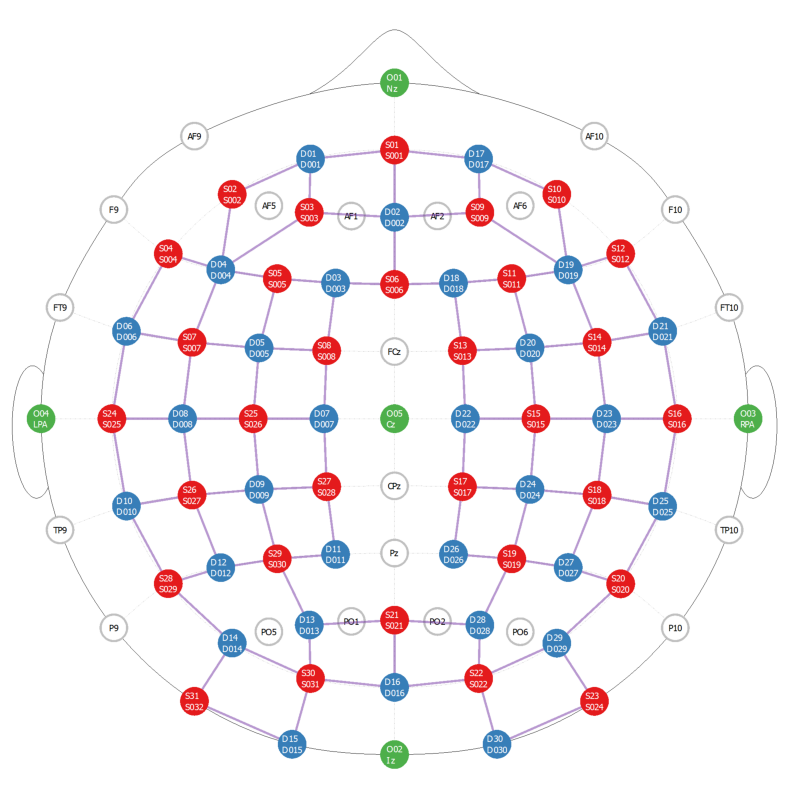

In [ ]:
# show montage (png image) in fname_montage
# Load the image
img = mpimg.imread(fname_montage)

# Display the image
plt.figure(figsize=(12, 10)) 
plt.imshow(img)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

Determination of evenly spreaded optodes across the head surface:

In [ ]:
spread_point_labels = find_spread_points(filtered_montage_elements)
print("Select those points")
print(spread_point_labels)

points = []
pvplt = pv.Plotter()
cedalion.plots.plot_surface(pvplt, s, opacity=1.0)
cedalion.plots.plot_labeled_points(pvplt, sticker_centers, color="r", ppoints = points)
#cedalion.plots.plot_vector_field(plt, sticker_centers, normals)
pvplt.show()

(index of points for debugging purposes)

In [ ]:
# for documentation purposes and to enable automatically rendered example notebooks we provide the hand-picked coordinates here too.
labeled_points = [15, 54, 51]
# uncomment if you want to use your manually picked points from above
# labeled_points = points
labeled_points

Write the selected labels to the corresponding points of *xarray.DataArray scalp_coords*

In [ ]:
new_labels = scalp_coords_altcase.label.values.copy()
for i,idx in enumerate(labeled_points): 
    new_labels[idx] = spread_point_labels[i]
scalp_coords_altcase = scalp_coords_altcase.assign_coords(label=new_labels)
scalp_coords_altcase

Find the affine transformation for the newly labeled points and apply it to the montage optodes

In [51]:
trafo2 = cedalion.geometry.registration.register_trans_rot(scalp_coords_altcase, montage_elements)

filtered_montage_elements = montage_elements.where((montage_elements.type == cdc.PointType.SOURCE) | (montage_elements.type == cdc.PointType.DETECTOR), drop=True)
filtered_montage_elements_t = filtered_montage_elements.points.apply_transform(trafo2)

and run ICP algorithm for label assignment once again, extract labels for detected optodes and plot the results

In [ ]:
# iterative closest point registration
idx = cedalion.geometry.registration.icp_with_full_transform(scalp_coords_altcase, 
                                                                            filtered_montage_elements_t, max_iterations = 100) 
# extract labels for detected optodes
label_dict = {}
for i, label in enumerate(filtered_montage_elements.coords['label'].values):
    label_dict[i] = label
labels = [label_dict[index] for index in idx]

# write labels to scalp_coords
scalp_coords_altcase = scalp_coords_altcase.assign_coords(label=labels)


## visualize results to verify
# Green points represent optode centers
# Next to them there shall be labels assumed by ICP algorithm (*show_labels = True*)
pvplt = pv.Plotter()
cedalion.plots.plot3d(None, s.mesh, filtered_montage_elements_t, None, plotter = pvplt) 
cedalion.plots.plot_labeled_points(pvplt, scalp_coords, color="green", show_labels = True)
pvplt.show(interactive = True)

### Combine all coregistered points into a new geo3d for further use 
e.g. (to save or update an existing geo3D field in a recording  container)

In [53]:
geo3Dscan_alt = geo3d_from_scan(scalp_coords_altcase, landmarks)

Visualization of successfull assignment *(show_labels = True)*

In [ ]:
pvplt = pv.Plotter()
cedalion.plots.plot3d(None, s.mesh, None, None, plotter = pvplt) 
cedalion.plots.plot_labeled_points(pvplt, geo3Dscan_alt, show_labels = True)
pvplt.show()